<a href="https://colab.research.google.com/github/lechemrc/DS-Unit-2-Kaggle-Challenge/blob/master/Rob_LeCheminant_DS7_Sprint_Challenge_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

### Colab Setup

In [1]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install packages in Colab
    !pip install category_encoders==2.0.0
    !pip install pandas-profiling==2.3.0
    !pip install plotly==4.1.1

### Important Imports

In [0]:
# libraries and math functions
import pandas as pd
import numpy as np
import pandas_profiling
import datetime as dt
from scipy.stats import randint, uniform

# imports for pipeline and regression
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels


# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



### Reading in dataset / Data Exploration

#### Reading in dataset

In [0]:
# Read data
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date'])

# Check data shape
assert df.shape == (13958, 20)

#### Exploring Dataset

In [123]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [124]:
columns = df.columns
columns

Index(['game_id', 'game_event_id', 'player_name', 'period',
       'minutes_remaining', 'seconds_remaining', 'action_type', 'shot_type',
       'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'shot_distance',
       'loc_x', 'loc_y', 'shot_made_flag', 'game_date', 'htm', 'vtm',
       'season_type', 'scoremargin_before_shot'],
      dtype='object')

## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

#### Majority Class

In [125]:
df['shot_made_flag'].value_counts(normalize=True)

0    0.527081
1    0.472919
Name: shot_made_flag, dtype: float64

The majority class baseline in this case is approximately 53% of shots were missed. I have to improve upon 53% from here. 

In [126]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [0]:
# Making sure 'game_date' is set to datetime format
# df['game_date'] = pd.to_datetime(df['game_date'], infer_datetime_format=True)
# df['game_date'].head()

In [128]:
# Setting date range for test subset
test = df[(df['game_date'] >= '2018-10-01') & (df['game_date'] <= '2019-06-30')]

test.shape

(1709, 20)

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [129]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [130]:
df['htm'].value_counts()

GSW    6871
HOU     440
POR     411
LAC     390
MEM     351
OKC     349
CLE     320
SAC     314
DEN     303
SAS     295
UTA     294
PHX     293
NOP     274
MIN     270
DAL     266
LAL     252
TOR     186
WAS     183
CHA     173
PHI     172
MIA     164
ORL     162
NYK     160
ATL     160
BOS     151
BKN     146
CHI     141
MIL     133
DET     124
IND     109
NOH      73
NJN      28
Name: htm, dtype: int64

#### Engineering Home Advantage

In [131]:
df['home_advantage'] = df['htm'].copy()

for i in df['home_advantage']:
  if i != str('GSW'):
    df['home_advantage'].replace(i, 'Other', inplace=True)

df['home_advantage'][df['home_advantage'] == 'GSW'] = 1
df['home_advantage'][df['home_advantage'] == 'Other'] = 0

df['home_advantage'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



0    7087
1    6871
Name: home_advantage, dtype: int64

In [132]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,home_advantage
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,1
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,1


#### Shot Percent per zone feature

In [133]:
shot_percent_zone = df.groupby('shot_zone_area')['shot_made_flag'].mean().reset_index()
shot_percent_zone

,shot_zone_area,shot_made_flag
0,Back Court(BC),0.059406
1,Center(C),0.512611
2,Left Side Center(LC),0.439295
3,Left Side(L),0.477237
4,Right Side Center(RC),0.440497
5,Right Side(R),0.454880


In [134]:
df['shot_percent_zone'] = df.groupby('shot_zone_area')['shot_made_flag'].transform('mean')
df['shot_percent_distance'] = df.groupby('shot_distance')['shot_made_flag'].transform('mean')
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,home_advantage,shot_percent_zone,shot_percent_distance
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1,0.440497,0.412632
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,1,0.439295,0.458432
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1,0.512611,0.494382
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1,0.477237,0.461039
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,1,0.439295,0.483333


## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [179]:
# setting features, target, X, and y ... features being all but target
train, val = train_test_split(df, train_size=0.80, test_size=0.20, random_state=42)
train.shape, val.shape

((11166, 23), (2792, 23))

In [180]:
test = df[(df['game_date'] >= '2018-10-01') & (df['game_date'] <= '2019-06-30')]

test.shape

(1709, 23)

In [197]:
# Setting target and features
target = 'shot_made_flag'
features = df.columns.drop([target, 'game_date'])

# Setting values for regressor 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, features

((11166, 21),
 (11166,),
 (2792, 21),
 (2792,),
 (1709, 21),
 Index(['game_id', 'game_event_id', 'player_name', 'period',
        'minutes_remaining', 'seconds_remaining', 'action_type', 'shot_type',
        'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'shot_distance',
        'loc_x', 'loc_y', 'htm', 'vtm', 'season_type',
        'scoremargin_before_shot', 'home_advantage', 'shot_percent_zone',
        'shot_percent_distance'],
       dtype='object'))

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [0]:
# Create RandomForestClassifier
random_forest = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_val)

## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [199]:
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.6436246418338109


## 7. Get your model's test accuracy

> (One time, at the end.)

In [201]:
y_pred = random_forest.predict(X_test)
print('Validation Accuracy', accuracy_score(y_test, y_pred))

Validation Accuracy 0.9332943241661791


It looks like I was able to get a 93% accuracy from my training set when applied to my test set, which I feel good about.

## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

#### Confusion Matrix

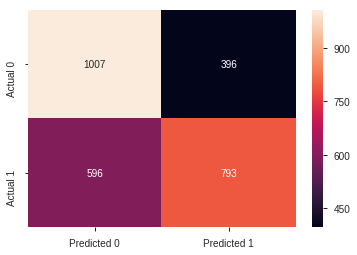

In [160]:
# confusion_matrix(y_val, y_pred)

def plot_confusion_matrix(y_true, y_pred):
  labels = unique_labels(y_pred)
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]

  table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                      columns=columns, index=index)
  return sns.heatmap(table, annot=True, fmt='d')

plot_confusion_matrix(y_val, y_pred);

### Calculate accuracy 

In [162]:
correct_predictions = 793 + 1007
total_predictions = 1007 + 396 + 596 + 793
accuracy = correct_predictions / total_predictions
accuracy

0.6446991404011462

### Calculate precision

In [169]:
correct_shots_pred = 793
total_shots_pred = 396 + 793
precision = correct_shots_pred / total_shots_pred
precision

0.6669470142977292

In [171]:
# To verify above calculation
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.72      0.67      1403
           1       0.67      0.57      0.62      1389

    accuracy                           0.64      2792
   macro avg       0.65      0.64      0.64      2792
weighted avg       0.65      0.64      0.64      2792



### Calculate recall

In [170]:
actual_shot_pred = 596 + 793
recall = correct_shots_pred / actual_shot_pred
recall

0.5709143268538517

In [168]:
# To verify above calculation
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.72      0.67      1403
           1       0.67      0.57      0.62      1389

    accuracy                           0.64      2792
   macro avg       0.65      0.64      0.64      2792
weighted avg       0.65      0.64      0.64      2792



### Feature Importances

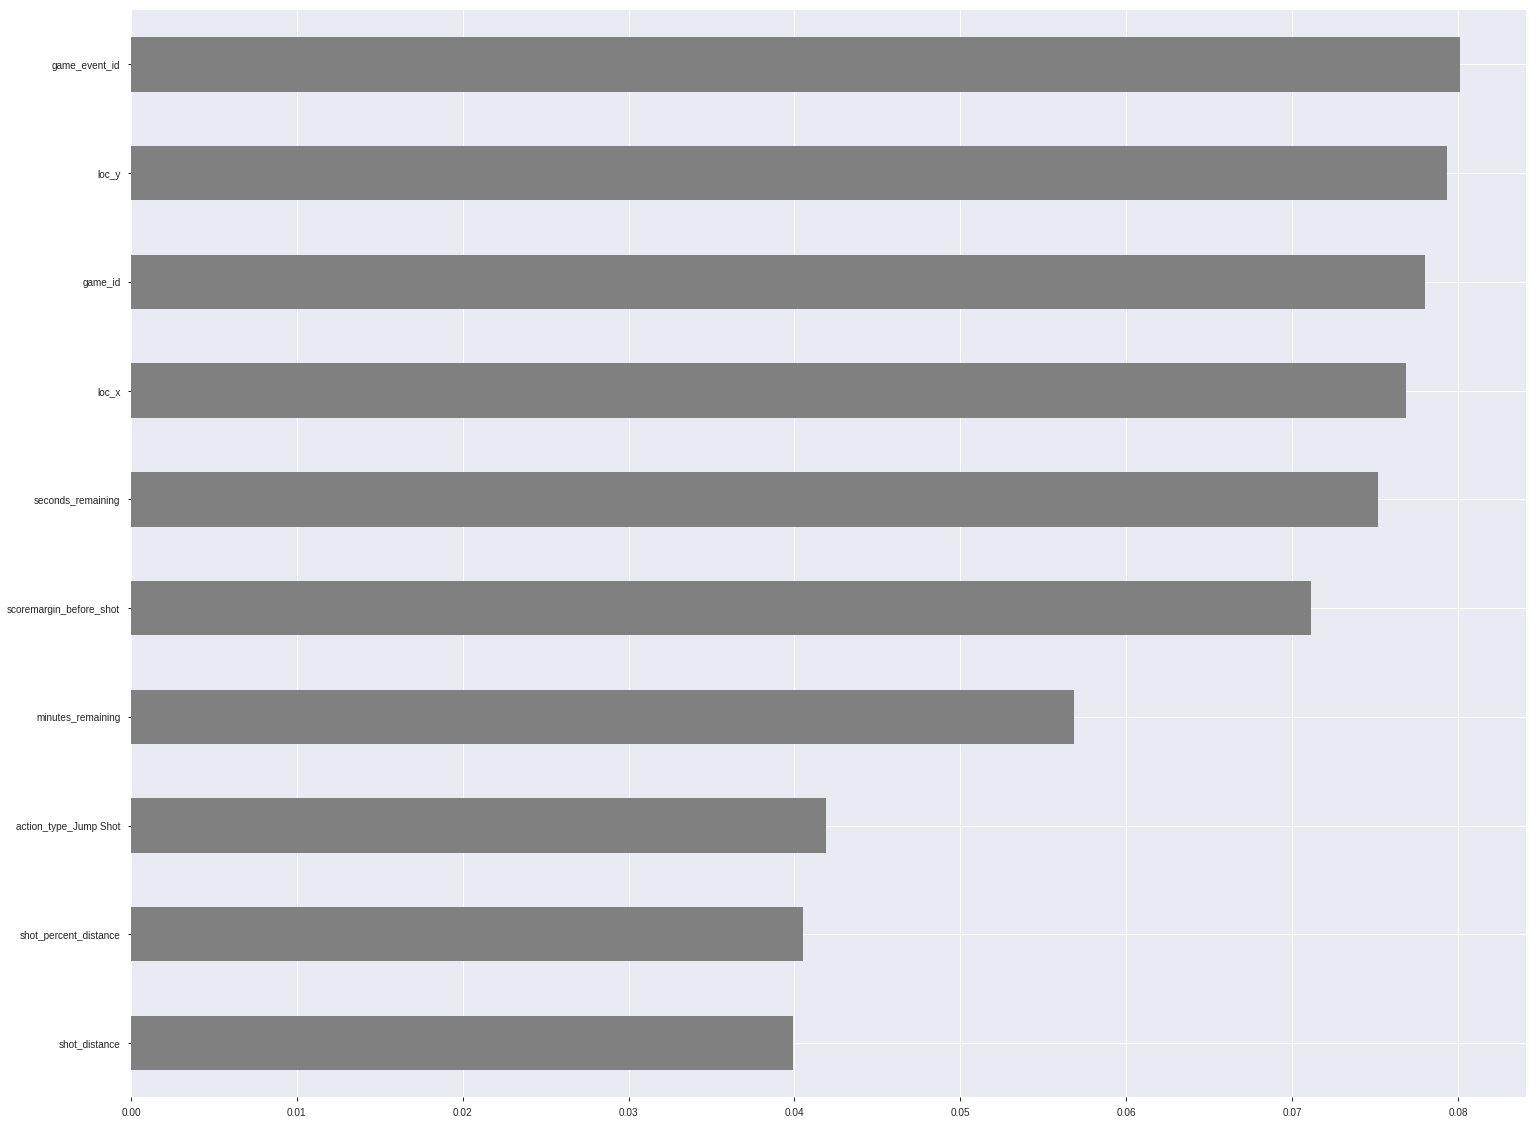

In [203]:
model= random_forest.named_steps['randomforestclassifier']
encoder = random_forest.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)

# plotting
plt.figure(figsize=(25,20))
importances = importances.sort_values()[-10:]
# trying to show the top 10 values
importances.plot.barh(color='grey')
plt.show()

#### Threshold

False    1711
True     1081
dtype: int64

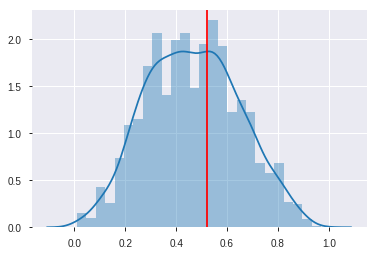

In [209]:
threshold = 0.52

y_pred_proba = pipeline.predict_proba(X_val)[:,1]
ax = sns.distplot(y_pred_proba)
ax.axvline(threshold, color='r');

y_pred = y_pred_proba > threshold
pd.Series(y_pred).value_counts()